# Import packages

In [1]:
# # Uncomment and run this cell if you don't have spmsimu package installed
# # or run this notebook on Cloud
# !pip install spmsimu

In [2]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from spmsimu.simulator import *

# Let's generate the ground truth patterns

## Checkerboard pattern

In [5]:
print(generate_pattern.__doc__)


    Generate ground-trutn patterns for scan simulation.
    
    Inputs:
        nx - int: number of pixels along x direction
        ny - int: number of pixels along y direction
        pattern - string: choose between "checkerboard", "spiral", and "atomic"
        num - int: number of features (boxes, spirals, or atoms) in the pattern
        turns - int: controls the curvature of spirals (only for "spiral")
        show - boolean: if True, the generated pattern will be displayed
        
    Output:
        pattern_map - ndarray: 2D map with ground-truth patterns
    


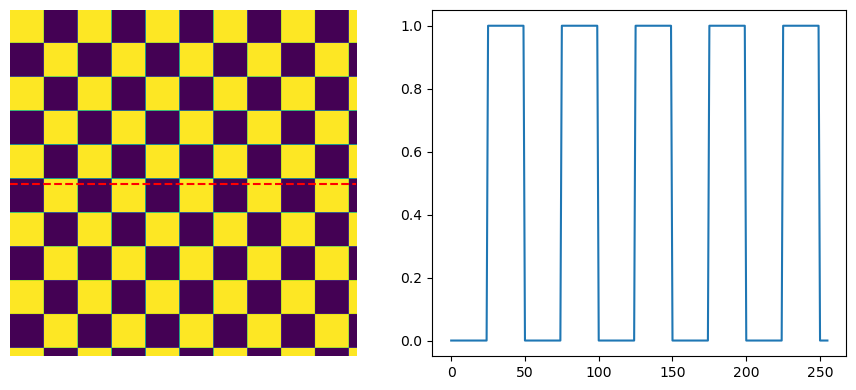

In [6]:
# Generate the checkerboard pattern
checkerboard = generate_pattern(nx=256, ny=256, pattern='checkerboard', num=10, show=True)


## Spiral pattern

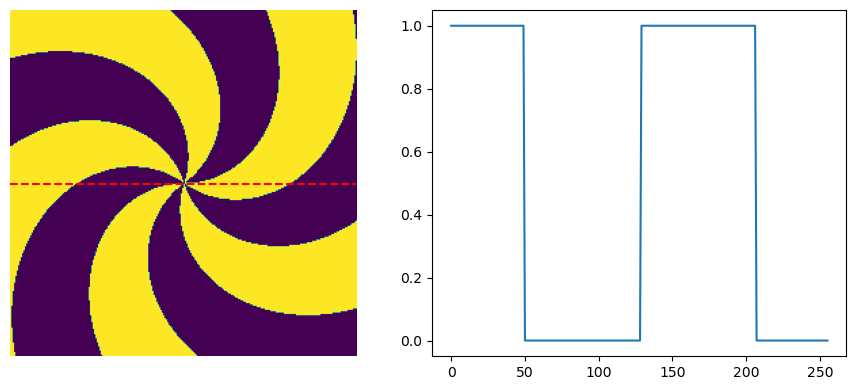

In [12]:
spiral = generate_pattern(nx=256, ny=256, pattern='spiral', num=10, turns=5, show=True)


## Atomic Lattice (cubic)

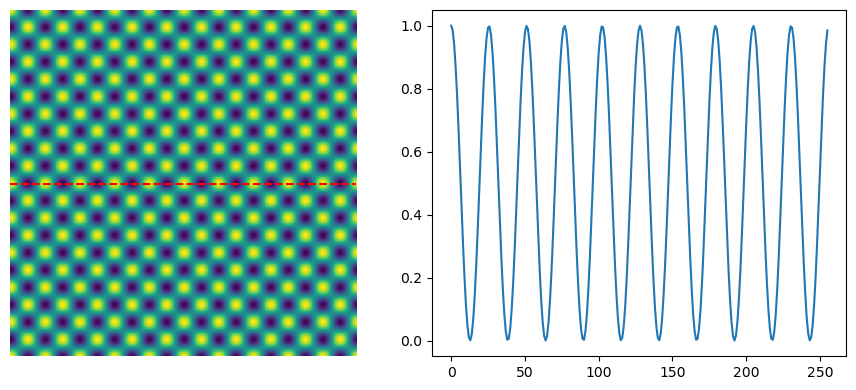

In [13]:
atomic = generate_pattern(nx=256, ny=256, pattern='atomic', num=10, show=True)


## Use real topography maps as ground-truth pattern

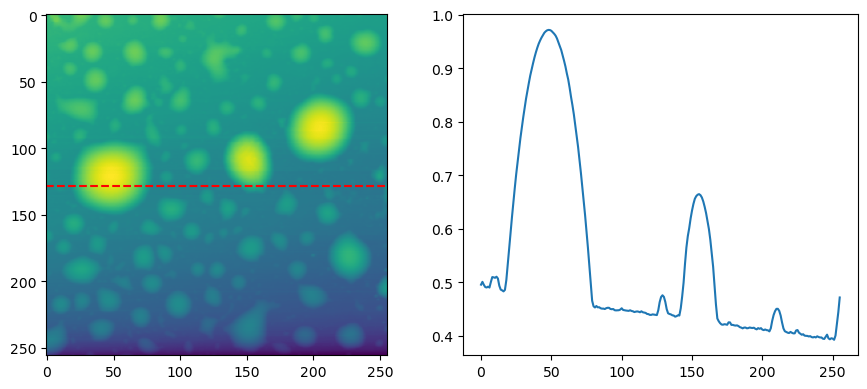

In [16]:
data = np.load('droplets.npy')

droplets = normalize(data[0], center=False)

nx, ny = np.shape(droplets)

fig, ax = plt.subplots(1, 2, figsize=[9,4])
ax[0].imshow(droplets)
ax[0].axhline(nx // 2, linestyle='--', color='r')
ax[1].plot(droplets[nx//2])
plt.tight_layout()

# Generate tip with different shapes

## ideal tip -- single and sharp

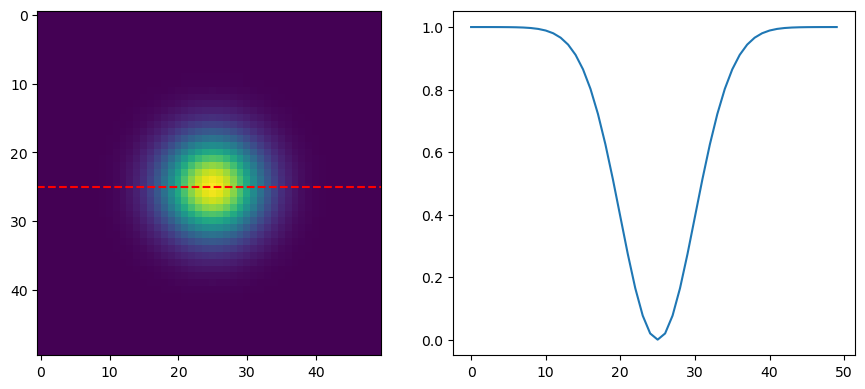

In [22]:
kernel_size = 50 # size of kernel in pixels
wx = 5   # x width of the probe in pixels
wy = 5   # y width of the probe in pixels

tip_ideal = generate_tip_kernel(kernel_size, wx, wy)

nx, ny = np.shape(tip_ideal)
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(tip_ideal)
ax[0].axhline(nx//2, color='r', linestyle='--')
ax[1].plot(1-tip_ideal[nx//2])
plt.tight_layout()

## Non-ideal tip -- blune tip

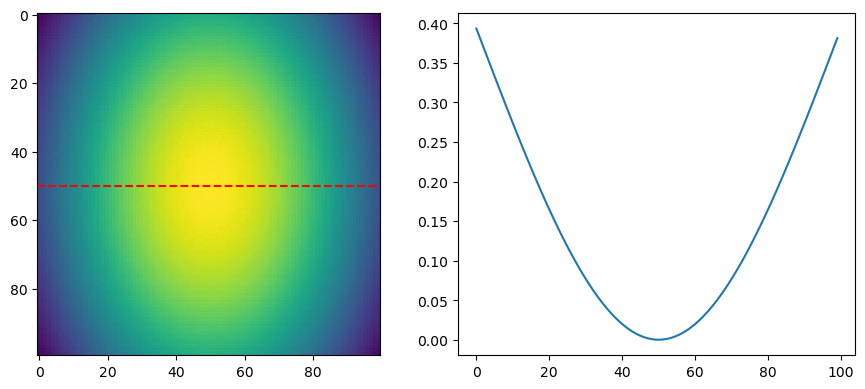

In [21]:
kernel_size = 100 # size of kernel in pixels
wx = 50   # x width of the probe in pixels
wy = 75   # y width of the probe in pixels

tip_blunt = generate_tip_kernel(kernel_size, wx, wy)

nx, ny = np.shape(tip_blunt)
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(tip_blunt)
ax[0].axhline(nx//2, color='r', linestyle='--')
ax[1].plot(1-tip_blunt[nx//2])
plt.tight_layout()

## Non-ideal tip -- double tip

In [27]:
print(generate_doubletip_kernel.__doc__)


    Generate the kernel for double tip, with tip1: [x_width, y_width, tip_height]
    The two tips are separated by offset.
    Everything is in the unit of pixels.
    


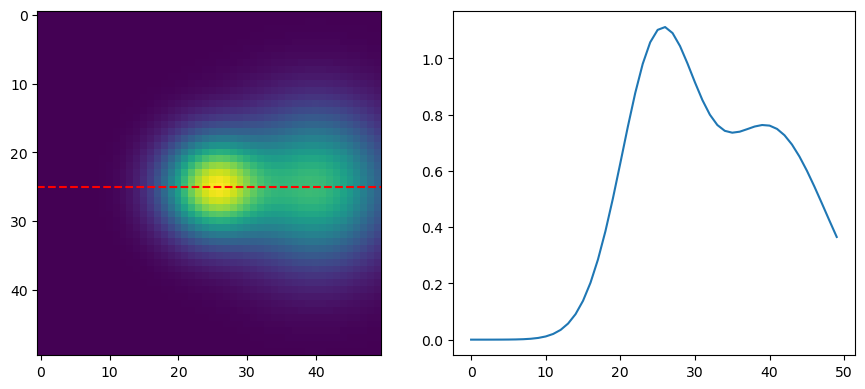

In [28]:
kernel_size = 50
wx1 = 5   # x width of the probe 1
wy1 = 5   # y width of the probe 1
amp1 = 1  # amplitude for probe 1

wx2 = 7.5   # x width of the probe 2
wy2 = 7.5   # y width of the probe 2
amp2 = 0.75  # amplitude for probe 2

offset = [15, 0] # this one controls the separation of two tips

tip_double = generate_doubletip_kernel(kernel_size=kernel_size, offset=offset,tip1=[wx1, wy1, amp1], tip2=[wx2, wy2, amp2])
nx, ny = np.shape(tip_double)
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].imshow(tip_double)
ax[0].axhline(nx//2, color='r', linestyle='--')
ax[1].plot(tip_double[nx//2])
plt.tight_layout()

# Simulate realistic scans

In [43]:
# generate ground-truth patterns and ideal tip shape
checkerboard = generate_pattern(nx=256, ny=256, pattern='checkerboard', num=10, show=False)

tip_ideal = generate_tip_kernel(kernel_size=50, wx=2.5, wy=2.5)

In [44]:
print(scan.__doc__)


    Generate realistic scan images based on the ground truth image, tip shape kernel, and scanning parameters.
    Input:
        image      - ndarray: ground truth 1D or 2D image profile
        kernel     - ndarray: tip shape kernel
        drive      - float: the drive amplitude (free-air amplitude)
        setpoint   - float: setpoint amplitude (setpoint tip-sample distance in the simulator)
        P          - float: proportional gain in PID
        I          - float: integral gain in PID
        length     - int: the number of pixels in "memory" of PID algorithm
        z_speed    - float: the extend/retrace speed of the z piezo
        scan_speed - float: the xy movement speed of the tip
        phase      - boolean: if true, a corresponding phase map is generated along with the height map
        retrace    - boolean: if true, both trace and retrace maps will be generated

    output:
        Realistic scan image generated based on ground truth image, tip shape kernel, and s

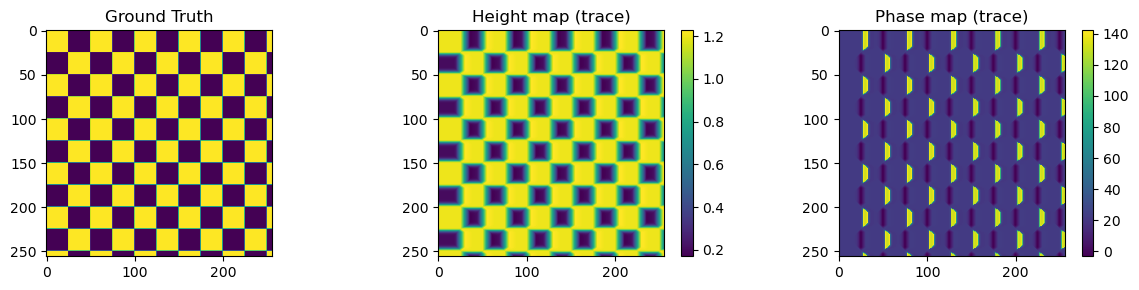

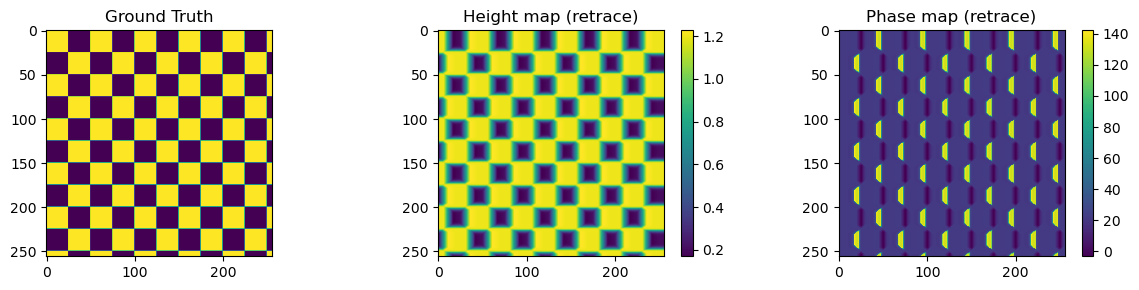

In [65]:
# This is the function to include everything:
traces = scan(image=checkerboard, kernel=tip_ideal, drive=0.5, setpoint=0.2,
          P=1, I=1e-2, z_speed=0.1, scan_speed=1, phase=True, retrace=True)

z1, ph1, z2, ph2 = traces

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z1)
im2 = ax[2].imshow(ph1)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (trace)')
ax[2].set_title('Phase map (trace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z2)
im2 = ax[2].imshow(ph2)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (retrace)')
ax[2].set_title('Phase map (retrace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

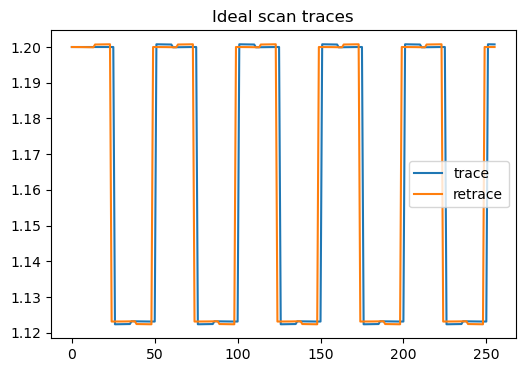

In [66]:
plt.figure(figsize=[6,4])
plt.plot(z1[100], label='trace')
plt.plot(z2[100][::-1], label='retrace')
plt.title('Ideal scan traces')
plt.legend()

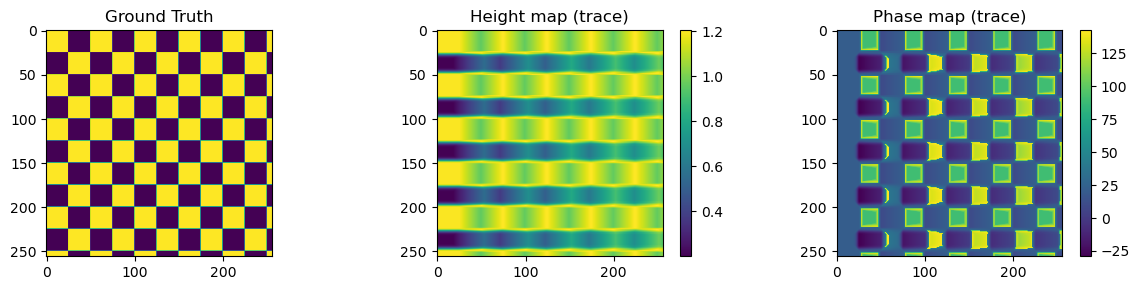

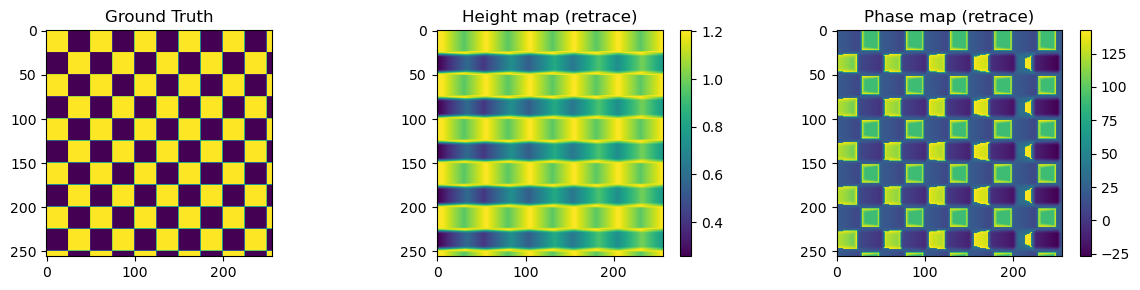

In [67]:
# If we use too small z_speed or too large scan speed, will we get parachutting effect?

# Here we have decreased the z_speed from 1e-1 to 1e-2:
traces = scan(image=checkerboard, kernel=tip_ideal, drive=0.5, setpoint=0.2,
          P=1, I=1e-2, z_speed=1e-2, scan_speed=1, phase=True, retrace=True)

z1, ph1, z2, ph2 = traces

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z1)
im2 = ax[2].imshow(ph1)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (trace)')
ax[2].set_title('Phase map (trace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z2)
im2 = ax[2].imshow(ph2)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (retrace)')
ax[2].set_title('Phase map (retrace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

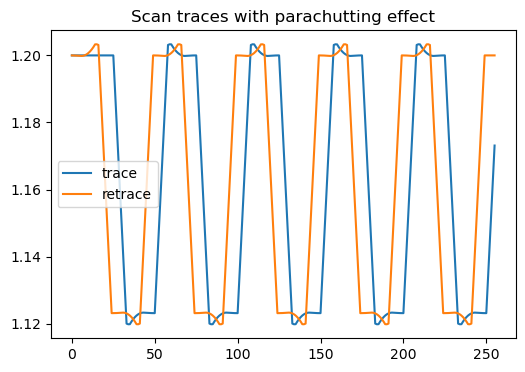

In [68]:
plt.figure(figsize=[6,4])
plt.plot(z1[100], label='trace')
plt.plot(z2[100][::-1], label='retrace')
plt.title('Scan traces with parachutting effect')
plt.legend()

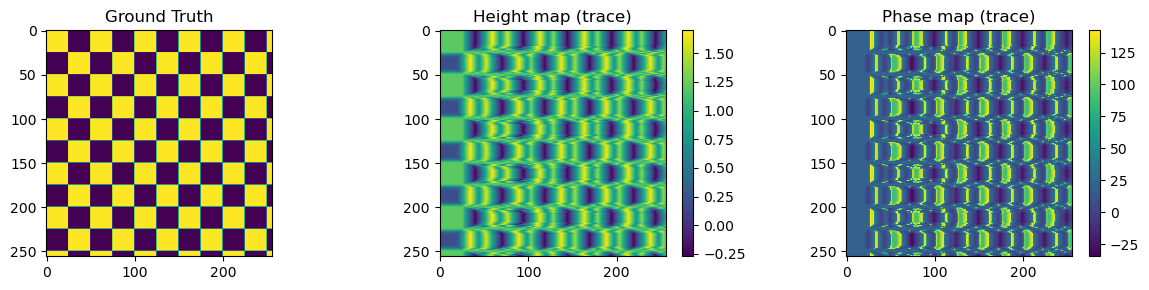

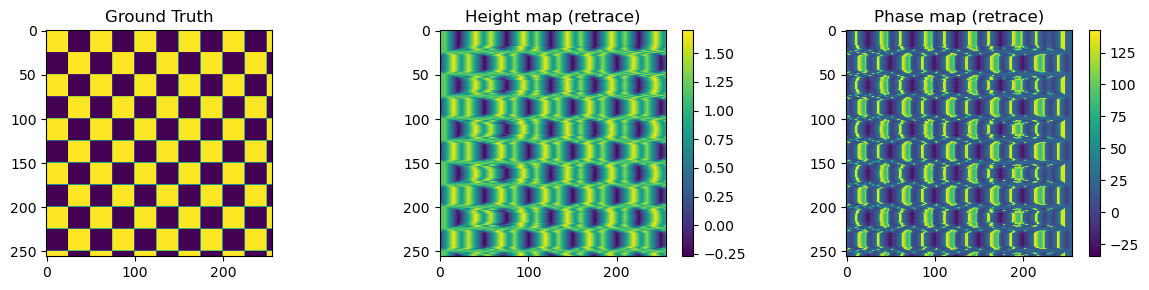

In [69]:
# If we used a too large I Gain, there will be oscillation in the map

# If we use too small z_speed, will we get parachutting effect?

# Here we have decreased the I Gain from 1e-2 to 1:
traces = scan(image=checkerboard, kernel=tip_ideal, drive=0.5, setpoint=0.2,
          P=1, I=1, z_speed=1e-1, scan_speed=1, phase=True, retrace=True)

z1, ph1, z2, ph2 = traces

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z1)
im2 = ax[2].imshow(ph1)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (trace)')
ax[2].set_title('Phase map (trace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

fig, ax=plt.subplots(1,3,figsize=[12,3])
ax[0].imshow(checkerboard)
im1 = ax[1].imshow(z2)
im2 = ax[2].imshow(ph2)

ax[0].set_title('Ground Truth')
ax[1].set_title('Height map (retrace)')
ax[2].set_title('Phase map (retrace)')

plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()

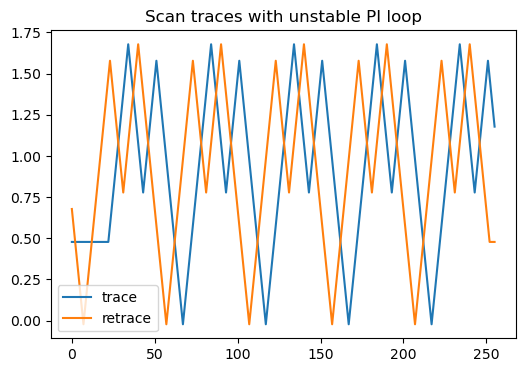

In [71]:
plt.figure(figsize=[6,4])
plt.plot(z1[128], label='trace')
plt.plot(z2[128][::-1], label='retrace')
plt.title('Scan traces with unstable PI loop')
plt.legend()

# Simulate tip scans

## With tip shape effect added

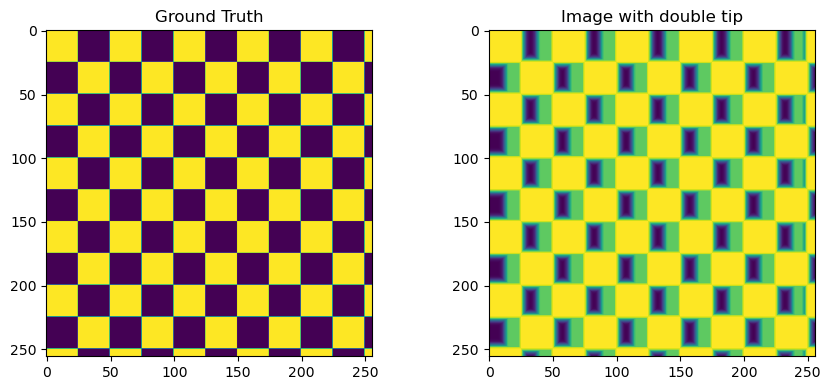

In [38]:
# Here we only consider the tip shape effect
checkerboard = generate_pattern(nx=256, ny=256, pattern='checkerboard', num=10, show=False)

kernel_size = 100
wx1 = 2.5   # x width of the probe 1
wy1 = 2.5   # y width of the probe 1
amp1 = 1  # amplitude for probe 1

wx2 = 2.5   # x width of the probe 2
wy2 = 2.5   # y width of the probe 2
amp2 = 0.75  # amplitude for probe 2

offset = [10, 0] # this one controls the separation of two tips

tip_double = generate_doubletip_kernel(kernel_size=kernel_size, offset=offset,tip1=[wx1, wy1, amp1], tip2=[wx2, wy2, amp2])

checkerboard_scan = tip_scan(checkerboard, tip_double)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(checkerboard)
ax[1].imshow(checkerboard_scan)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with double tip')

plt.tight_layout()

## With PI parameters added

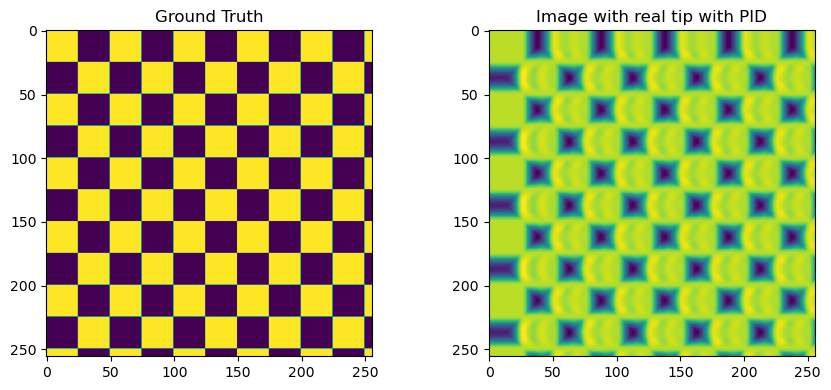

In [39]:
# Scanning with a real tip and real PID settings

tip_ideal = generate_tip_kernel(kernel_size=50, wx=5, wy=5)
checkerboard_scan = tip_scan(checkerboard, tip_ideal)
checkerboard_PI = pi_loop(checkerboard_scan, P=0.5, I=1e-1)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(checkerboard)
ax[1].imshow(checkerboard_PI)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with real tip with PID')
plt.tight_layout()

## Simulate tip change events

In [73]:
print(scanning_tip_change.__doc__)


    Simulate the scanning with tip change and/or PI setting changes.
    Input:
        img: ground truth image pattern
        kernel1: tip kernel before tip change event
        kernel2: tip kernel after tip change event. If not provided, will be the same as kernel1
        pi1: [P, I] settings for the PI before tip change event
        pi2: [P, I] settings for the PI after tip change event. If not provided, will be the same as pi1
    


In [72]:

kernel_size = 50
wx = 2.5   # x width of the probe
wy = 2.5   # y width of the probe

# Initial tip kernel
tip_before = generate_tip_kernel(kernel_size, wx=2.5, wy=2.5, tip_height=1)

# Tip kernel after tip change -- it's shorter and more blunt
tip_after = generate_tip_kernel(kernel_size, wx=5, wy=5, tip_height=0.5)

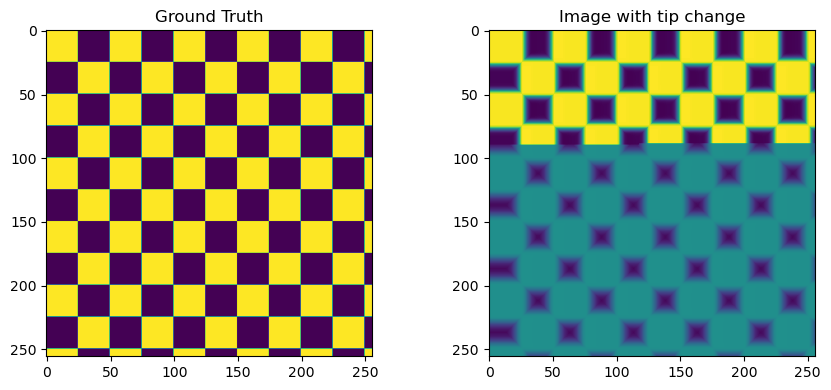

In [77]:
checkerboard_tip_change = scanning_tip_change(checkerboard, tip_before, pi1=[1, 1e-2], kernel2=tip_after, pi2=None)

fig, ax=plt.subplots(1,2,figsize=[9,4])
ax[0].imshow(checkerboard)
ax[1].imshow(checkerboard_tip_change)

ax[0].set_title('Ground Truth')
ax[1].set_title('Image with tip change')
plt.tight_layout()